# Deep Learning &mdash; Assignment 4

Fourth assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:**
Enrico Schmitz (s1047521) & Charlotte Cambier van Nooten (s1044122)

**Group:**
Group 22

-----


**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Train and modify a transformer network
2. Experiment with a translation dataset


## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install torch
!pip install d2l
#!pip install torchvision

In [2]:
from d2l import torch as d2l
import math
import numpy as np
import torch
from torch import nn

## 4.1 Transformer

There is a detailed description of the transformer model in chapter 10.3 of the d2l book. In this exercise we will do experiments with variations on this model.

**Run the code from that chapter, to train a transformer model on a English->French toy translation dataset**  
Note: Make sure that you use the pytorch version.

***Code from the chapter (copy)***

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).

        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            valid_len = torch.repeat_interleave(valid_len, repeats=self.num_heads, dim=0)

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)

        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output

def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [4]:
cell = MultiHeadAttention(5, 5, 5, 100, 10, 0.5)
cell.eval()
X = torch.ones((2, 4, 5))
valid_len = torch.tensor([2, 3])
cell(X, X, X, valid_len).shape

torch.Size([2, 4, 100])

In [5]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, pw_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, pw_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [6]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.2210,  0.3778,  0.2090, -0.0087, -0.4113, -0.1710,  0.1377,  0.3490],
        [-0.2210,  0.3778,  0.2090, -0.0087, -0.4113, -0.1710,  0.1377,  0.3490],
        [-0.2210,  0.3778,  0.2090, -0.0087, -0.4113, -0.1710,  0.1377,  0.3490]],
       grad_fn=<SelectBackward>)

In [7]:
layer = nn.LayerNorm([2])
layer.eval()
batch = nn.BatchNorm1d(2)
batch.eval()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', layer(X), '\nbatch norm:', batch(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[1.0000, 2.0000],
        [2.0000, 3.0000]], grad_fn=<NativeBatchNormBackward>)


In [8]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [9]:
add_norm = AddNorm([3,4], 0.5) # normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

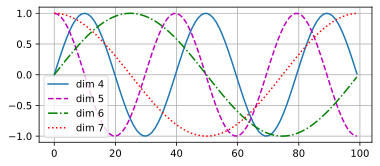

In [11]:
pe = PositionalEncoding(20, 0)
pe.eval()
Y = pe(torch.zeros((1, 100, 20)))
d2l.plot(torch.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_len):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))

In [13]:
X = torch.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_len).shape

torch.Size([2, 100, 24])

In [14]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             dropout, use_bias))

    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X

In [15]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_len).shape

torch.Size([2, 100, 24])

In [16]:
class DecoderBlock(nn.Module):
    # `i` means it is the i-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_len = torch.repeat_interleave(torch.arange(1, seq_len + 1, device=X.device),
                                                batch_size, dim=0)
            # Convert valid_len to 2D
            if valid_len.shape[0]!=X.shape[0]:
                valid_len = valid_len.reshape(-1, X.shape[1])
        else:
            valid_len = None

        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [17]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_len), valid_len, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [18]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

loss 0.016, 8229.3 tokens/sec on cuda:0


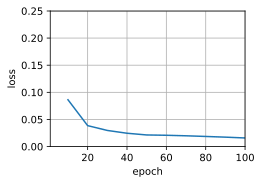

In [19]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, device)

In [20]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => <unk> !
Wow ! => <unk> !
I'm OK . => va bien .
I won ! => je l'ai emporté !


The example in the book uses a function `d2l.load_data_nmt` to load an English->French translation dataset. This function is implemented in chapter 9.5. This implementation produces only a single iterator over batches of data.

**Modify this function to randomly split the data into a training and test set.**

In [21]:
def load_data_nmt(batch_size, num_steps, train_fraction=0.8, num_examples=1000):
    text = d2l.preprocess_nmt(d2l.read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array(source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = d2l.build_array(target, tgt_vocab, num_steps, False)

    # Modified code to produce a training and test set
    data_arrays_np = (src_array.detach().cpu().numpy(), src_valid_len.detach().cpu().numpy(),
                   tgt_array.detach().cpu().numpy(), tgt_valid_len.detach().cpu().numpy())
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    training_idx = np.random.permutation(int(data_arrays_np[0].shape[0] * train_fraction))
    train_iter = d2l.load_array((src_array[training_idx], src_valid_len[training_idx], tgt_array[training_idx], tgt_valid_len[training_idx]),
                             batch_size, is_train=True)
    full_idx = list(range(int(data_arrays_np[0].shape[0])))
    test_idx = list(set(full_idx) - set(training_idx))    
    test_iter = d2l.load_array((src_array[test_idx], src_valid_len[test_idx], tgt_array[test_idx], tgt_valid_len[test_idx]),
                            batch_size, is_train=False)
    data_iter = (train_iter, test_iter)

    return src_vocab, tgt_vocab, data_iter

With a test set in hand, we can make more informed decisions when comparing different models. The simplest metric to implement is test set loss. Just like in previous weeks, it would be nice to plot the test metrics during training. To do that we will need to modify the `d2l.train_s2s_ch9` function, which is defined in chapter 9.7.

**Complete the implementation below**

In [22]:
def train_s2s(model, train_iter, test_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            legend=['train loss', 'test loss'],
                            xlim=[1, num_epochs+10], ylim=[0, 1])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in train_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1], None))
            test_loss = calculate_test_loss(model, loss, test_iter, device)
            animator.add(epoch, (None, test_loss))
    print(f'train loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'test loss {test_loss:.3f} '
          f'tokens/sec on {str(device)}')

def calculate_test_loss(model, loss, test_iter, device):
    # Calculating test loss
    metric = d2l.Accumulator(2)  # loss_sum, num_tokens
    for batch in test_iter:
      X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
      Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
      Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
      l_test = loss(Y_hat, Y_label, Y_vlen)
      l_test.sum().backward()
      d2l.grad_clipping(model, 1)
      num_tokens = Y_vlen.sum()
      with torch.no_grad():
        metric.add(l_test.sum(), num_tokens)
        
    return metric[0]/metric[1]


**Re-train the transformer model, this time showing test set loss. How does this compare to training set loss?**

train loss 0.017, 5120.1 test loss 0.389 tokens/sec on cuda:0


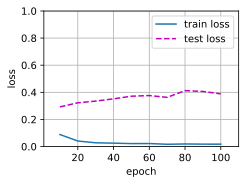

In [23]:
# Transformer model re-trained using test set loss
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

## 4.3 Data size

The model is only trained on 1000 sentence pairs. You can change this with the `num_examples` parameter to `load_data_nmt`.
When you do this, note that the code in d2l chapter 10.3 has a bug, where it uses the size of the *source* vocabulary (English in this case) for both the encoder and the decoder. You will run into this when using different amounts of data.

**Train with a larger dataset**

train loss 0.020, 7860.5 test loss 0.240 tokens/sec on cuda:0


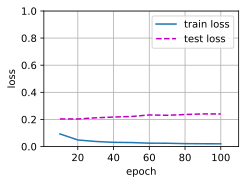

In [24]:
# Transformer model re-trained using larger dataset
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

By taking only the first 1000 samples we have limited ourselves to very simple sentences (see `data/fra.txt`). Later sentences in the dataset are longer.

**Will the code need to be modified to correctly handle these larger sentences?**

As seen above, the model performs better on the larger dataset, and so the larger sentences. Therefor we will modify the size in the implementations below. 

## 4.4 Variations

**Does dropout improve the test set performance?**

train loss 0.174, 7277.9 test loss 0.262 tokens/sec on cuda:0


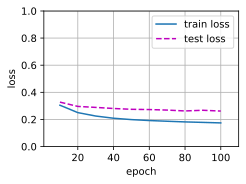

In [25]:
# Transformer model re-trained using dropout
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.5, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

Dropout can help with regularization.
While training the model, using dropout the will make some elements of the input equal to zero. This will be done with probability equal to `p` from Bernoulli distribution. We have set `p` equal to 0.5 to see the difference. Using this, the test performance has improved.

**Change the number of heads in the encoder and/or decoder. Do you see any difference in the results?**

train loss 0.019, 7247.3 test loss 0.266 tokens/sec on cuda:0


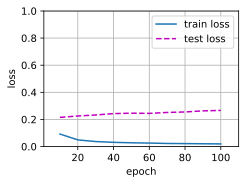

In [26]:
# Transformer model re-trained using different number of heads
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 16 #num_heads changed from 4 to 16
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

train loss 0.019, 7389.7 test loss 0.239 tokens/sec on cuda:0


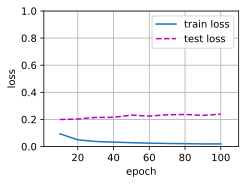

In [33]:
# Transformer model re-trained using different number of heads (only the encoder)
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads, num_heads_encoder = 32, 64, 4, 16 #num_heads changed from 4 to 16
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads_encoder,
    num_layers, dropout)
decoder = TransformerDecoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

train loss 0.019, 7958.1 test loss 0.259 tokens/sec on cuda:0


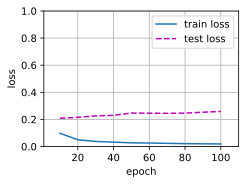

In [34]:
# Transformer model re-trained using different number of heads (only the decoder)
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads, num_heads_decoder = 32, 64, 4, 16 #num_heads changed from 4 to 16
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads_decoder,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

When changing the `number_heads` on both the encoder and decoder there is no improvement in the values of the losses. Only changing the `number_heads` in the encoder gives, an improvement when comparing to changing both, but not an improvement when comparing to the original tranformer with more data. Only changing the `number_heads` in the decoder also gives no improvement. 

**Look at the `MultiHeadAttention` module. Does the number of trainable parameters change with the number of heads? And if so, how?**

Each head in the MultiHeadAttention module is working as an attention function of the queries, keys and values. Each have a trainable parameters (W_q, W_k, W_v). So when changing the number of heads, dimensions should decrease

It should work better when increasing the number of heads, the dimensions of for instance the keys will be decreased. Heads will be able to collaborate en the dimensions are lower, so we would expect a performance, unfortunately we can't see this back into our results.

**What happens if you don't use any positional encoding? Can you explain why?**

In [27]:
class TransformerEncoder_nonPosEnc(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder_nonPosEnc, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             dropout, use_bias))

    def forward(self, X, valid_len, *args):
        X = self.embedding(X)
        for blk in self.blks:
            X = blk(X, valid_len)
        return X

In [28]:
class TransformerDecoder_nonPosEnc(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder_nonPosEnc, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.embedding(X)
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

train loss 0.019, 7214.4 test loss 0.268 tokens/sec on cuda:0


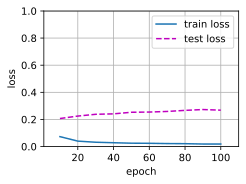

In [29]:
# Transformer model re-trained using it without positional encoding
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = TransformerEncoder_nonPosEnc(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder_nonPosEnc(
    larger_examples, key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

Without positional encoding the model can't track where the word was located in the original sentence. But the positioning of a word is very important regarding the meaning of the sentence. Thus leading to a lower preformance.

**What happens if you change only one of the `key_size`, `query_size` or `value_size`? Can you explain why?**

The hidden size (`num_hiddens`)are the same for the query, key, and value dense layers. The MultiheadAttention is keeping the same dimensions between the inputs and outputs. 
It would not be possible to change the `value_size`, `query_size` or `key_size`, both sizes must be in the same dimension. 
The sizes for the feature dimensions should be the same in MultiheadAttention. 


**Compare the results of the transformer with the LSTM network from d2l chapter 9.7. Discuss the differences**

In [30]:
# Function from the book (d2l)
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be time step, i.e., seq_len
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X) # When state is not mentioned, it defaults to zeros
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

In [31]:
# Function from the book (d2l)
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).permute(1, 0, 2)
        return out, state

train loss 0.027, 18172.2 test loss 0.531 tokens/sec on cuda:0


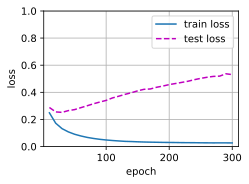

In [32]:
# LSTM model
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

larger_examples = 4000
src_vocab, tgt_vocab, data_iter = load_data_nmt(batch_size, num_steps, num_examples=larger_examples)

encoder = Seq2SeqEncoder(
    larger_examples, embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    larger_examples, embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, data_iter[0], data_iter[1], lr, num_epochs, device)

Transformer: train loss 0.017, 5120.1 test loss 0.389 tokens/sec on cuda

Variations (transformer)
*   Data size (4000): train loss 0.020, 7860.5 test loss 0.240 tokens/sec on cuda
*   Dropout: train loss 0.174, 7277.9 test loss 0.262 tokens/sec on cuda
*   Number of heads (4 to 16): train loss 0.019, 7247.3 test loss 0.266 tokens/sec on cuda
*   Positional encoding: train loss 0.019, 7214.4 test loss 0.268 tokens/sec on cuda

LSTM: train loss 0.027, 18172.2 test loss 0.531 tokens/sec on cuda

The LSTM has a somewhat higher train loss, and a much higher test loss. This can be because of overfitting. 

The LSTM model uses the state vector, the vector is able to encode words regarding the whole (english) sentence. So it gives the model all information. 
Using a transformer, we use the attention mechanism, model is able to learn to come to states of an earlier english words when translating the start of the french output. The transformer is able to have more context in the sentence. 





## The end

Well done! Please double check the instructions at the top before you submit your results.